In [1]:
%pylab inline
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


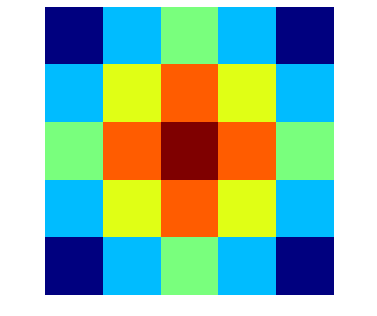

In [2]:
import scipy.ndimage.filters as fi

def gaussian_kernel(k_len = 5, sigma = 3):
    d_mat = zeros((k_len, k_len))
    d_mat[k_len//2, k_len//2] = 1
    return fi.gaussian_filter(d_mat, sigma)

OUTPUT_DIR = '../../content/images/constrained-ls-intro/'

axis('off')
ax = Axes(gcf(), [0,0,1,1])
ax.set_axis_off()
gcf().add_axes(ax)
ax.imshow(gaussian_kernel(), interpolation='nearest')
savefig(OUTPUT_DIR+'gaussian_kernel.png')

In [3]:
from scipy.signal import convolve2d
from scipy.ndimage import imread

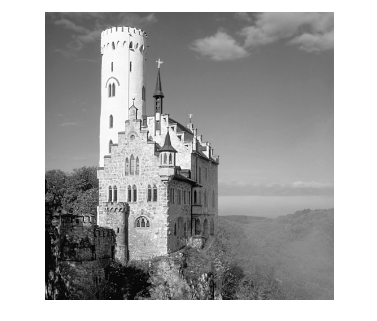

In [4]:
curr_img = imread('image_test.png')

grey_scale_img = .21*curr_img[:,:,0] + .72*curr_img[:,:,1] + .07*curr_img[:,:,2]
axis('off')
ax = Axes(gcf(), [0,0,1,1])
ax.set_axis_off()
gcf().add_axes(ax)
ax.imshow(grey_scale_img, cmap='Greys_r')
savefig(OUTPUT_DIR+'initial_image.png')

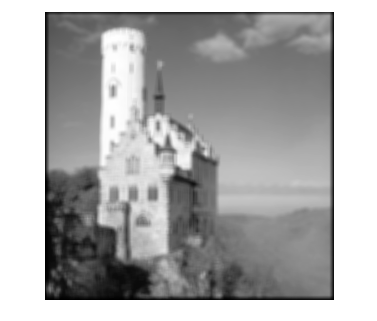

In [5]:
nitems, sigma = 9, 5
blurry_image = convolve2d(grey_scale_img, gaussian_kernel(nitems, sigma))
axis('off')
ax = Axes(gcf(), [0,0,1,1])
ax.set_axis_off()
gcf().add_axes(ax)
ax.imshow(blurry_image, cmap='Greys_r')
savefig(OUTPUT_DIR+'blurred_image.png')

In [6]:
import scipy.sparse as sparse
import scipy.linalg as linalg

In [7]:
def show_image(img):
    imshow(img, cmap="Greys_r")
    axis('off')

# Generates the toeplitz matrix for the 1D convolution
def toeplitz(b, n):
    m = len(b)
    T = zeros((n+m-1, n))
    for i in range(n+m-1):
        for j in range(n):
            if 0 <= i-j < m:
                T[i,j] = b[i-j]
    return T

In [8]:
toeplitz([1,2,3], 3)

array([[ 1.,  0.,  0.],
       [ 2.,  1.,  0.],
       [ 3.,  2.,  1.],
       [ 0.,  3.,  2.],
       [ 0.,  0.,  3.]])

In [9]:
N = 512

def gaussian1d(k_len = 5, sigma = 3):
    return gaussian_kernel(k_len, sigma)[k_len//2,:]

curr_1d_kernel = gaussian1d(nitems, sigma)

# Gaussian 1D kernel as matrix
T = toeplitz(curr_1d_kernel, 512)

row_mat = sparse.kron(sparse.eye(N), T)
col_mat = sparse.kron(T, sparse.eye(N+8))

In [10]:
new_blurred = col_mat.dot(row_mat.dot(grey_scale_img.flatten()))

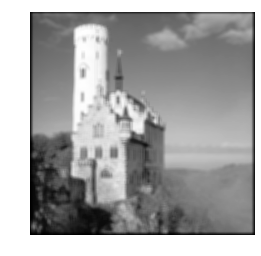

In [11]:
show_image(new_blurred.reshape((N+8,)*2))

In [12]:
G = col_mat.dot(row_mat)

In [13]:
flat_blurry_image = blurry_image.flatten()
def lst_sq(x, A=G, b=flat_blurry_image):
    return linalg.norm(b - A.dot(x))**2
def lst_sq_grad(x, A=G, b=flat_blurry_image):
    return 2*A.T.dot(A.dot(x) - b)
    
optim_output = optimize.minimize(lst_sq, np.zeros(N**2), method='L-BFGS-B', jac=lst_sq_grad, options={'disp':True})

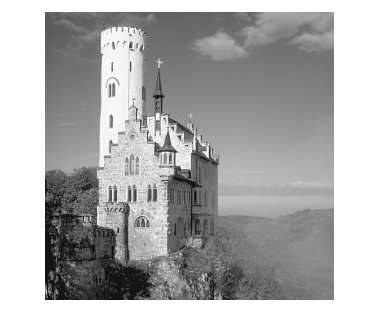

In [14]:
final_image = optim_output['x']

axis('off')
ax = Axes(gcf(), [0,0,1,1])
ax.set_axis_off()
gcf().add_axes(ax)
ax.imshow(final_image.reshape((N,)*2), cmap='Greys_r')
savefig(OUTPUT_DIR+'reconstructed_image.png')

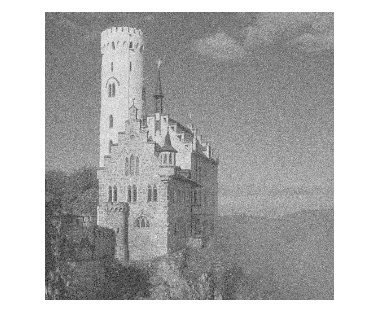

In [45]:
nitems, sigma = 9, 5
grey_scale_img_corrupted = grey_scale_img + 30*random.randn(*grey_scale_img.shape)
axis('off')
ax = Axes(gcf(), [0,0,1,1])
ax.set_axis_off()
gcf().add_axes(ax)
ax.imshow(grey_scale_img_corrupted, cmap='Greys_r')
savefig(OUTPUT_DIR+'corrupted_image.png')

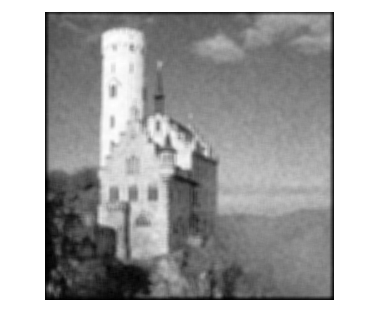

In [46]:
corrupted_blurry_image = convolve2d(grey_scale_img_corrupted, gaussian_kernel(nitems, sigma))
axis('off')
ax = Axes(gcf(), [0,0,1,1])
ax.set_axis_off()
gcf().add_axes(ax)
ax.imshow(corrupted_blurry_image, cmap='Greys_r')
savefig(OUTPUT_DIR+'corrupted_blurred_image.png')

In [47]:
c_flat_blurry_image = corrupted_blurry_image.flatten()
    
optim_output = optimize.minimize(lambda x: lst_sq(x, b=c_flat_blurry_image), np.zeros(N**2), method='L-BFGS-B', jac=lambda x: lst_sq_grad(x, b=c_flat_blurry_image), options={'disp':True})

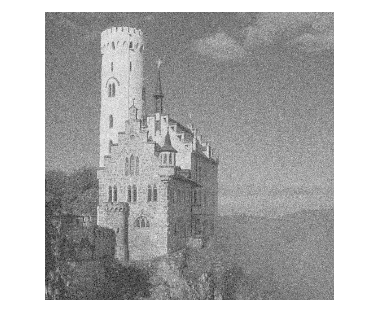

In [48]:
c_final_image = optim_output['x']

axis('off')
ax = Axes(gcf(), [0,0,1,1])
ax.set_axis_off()
gcf().add_axes(ax)
ax.imshow(c_final_image.reshape((N,)*2), cmap='Greys_r')
savefig(OUTPUT_DIR+'corrupted_reconstructed_image.png')

In [49]:
L = zeros((N-1, N))
i,j = indices(L.shape)
L[i==j] = 1
L[i==j-1] = -1

Dx = sparse.kron(sparse.eye(N), L)
Dy = sparse.kron(L, sparse.eye(N))

In [58]:
c_flat_blurry_image = corrupted_blurry_image.flatten()

l = 1e-10

def smoothed_sq(x, A=G, b=c_flat_blurry_image, l=l):
    return linalg.norm(b - A.dot(x))**2 + l*(linalg.norm(Dx.dot(x))**2 + linalg.norm(Dy.dot(x))**2)
def smoothed_sq_grad(x, A=G, b=c_flat_blurry_image, l=l):
    return 2*(A.T.dot(A.dot(x) - b) +l*(Dx.T.dot(Dx.dot(x)) + Dy.T.dot(Dy.dot(x))))
    
optim_output = optimize.minimize(lambda x: smoothed_sq(x),
                                 np.zeros(N**2),
                                 method='L-BFGS-B',
                                 jac=lambda x: smoothed_sq_grad(x),
                                 options={'disp':True})

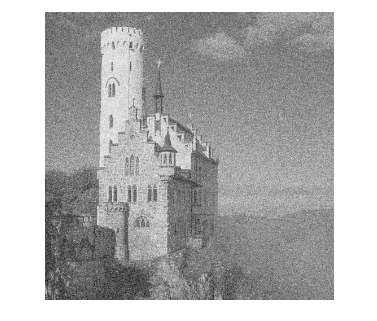

In [59]:
c_final_image_smooth = optim_output['x']

axis('off')
ax = Axes(gcf(), [0,0,1,1])
ax.set_axis_off()
gcf().add_axes(ax)
ax.imshow(c_final_image_smooth.reshape((N,)*2), cmap='Greys_r')
savefig(OUTPUT_DIR+'smoothed_corrupted_reconstructed_image_l={}.png'.format(l))